# Process data
1. Examine the raw data
2. Determine normalization based on examination

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene.zip")
normalized_data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")
metadata_file = os.path.join(os.path.dirname(os.getcwd()), "metadata", "sample_annotations.tsv")

In [3]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,7.838544,8.497065,7.307553,5.702930,5.916741,8.063651,7.886661,7.727567,6.892924,7.342850,...,7.072203,7.999211,8.198070,9.263671,7.543691,7.660837,7.939869,8.036795,7.422011,6.363520
0.1_2hr_CSV86(Pae_G1a).CEL,6.875033,6.776369,7.817901,7.785099,6.341328,8.819276,7.044294,6.209714,8.125990,6.579754,...,7.071695,8.125990,7.778503,8.144801,6.022443,7.066444,6.132326,7.254421,7.765065,6.449344
0.1_6hr_CSV86(Pae_G1a).CEL,7.842026,7.655701,7.677886,6.166077,6.871341,7.265597,7.113404,7.480186,6.930921,6.778917,...,6.098874,7.950371,6.434071,6.918956,6.844293,7.291937,7.427901,9.331491,7.098162,7.954667
0.1_7hr_CSV86(Pae_G1a).CEL,7.684676,8.201883,7.013697,7.005081,7.962038,8.061572,7.971468,7.638721,7.254758,4.959658,...,7.007845,6.760074,5.774510,7.288419,7.292321,7.118397,7.525591,7.329594,7.544611,7.192988
0.1_9hr_CSV86(Pae_G1a).CEL,6.685037,7.105100,8.192931,7.092900,7.989745,7.740668,8.214360,7.383215,6.933628,7.122736,...,6.410715,7.536854,5.792362,8.339486,6.536239,6.517288,6.991313,7.735386,7.375440,6.052557


In [4]:
# Read in data
metadata = pd.read_table(metadata_file, header=0, sep='\t', index_col='ml_data_source')
metadata

,experiment,sample_name,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
ml_data_source,,,,,,,,,,,,,,,,,
GSM1141730_PA01_ZnO_PZO_.CEL,E-GEOD-46947,GSM1141730 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
GSM1141729_PA01_none_PC_.CEL,E-GEOD-46947,GSM1141729 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
GSM1608059_Planktonic_1.CEL,E-GEOD-65882,GSM1608059 1,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608060_Planktonic_2.CEL,E-GEOD-65882,GSM1608060 1,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608061_Planktonic_3.CEL,E-GEOD-65882,GSM1608061 1,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608062_Planktonic_4.CEL,E-GEOD-65882,GSM1608062 1,PAO1 WT. Planktonic. Rep4,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608067_Biofilm+12hrcipro_rep1.CEL,E-GEOD-65882,GSM1608067 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608068_Biofilm+12hrcipro_rep2.CEL,E-GEOD-65882,GSM1608068 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608069_Biofilm+12hrcipro_rep3.CEL,E-GEOD-65882,GSM1608069 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN


In [5]:
# Select metadata field
metadata_field = 'strain'
metadata_selected = metadata[metadata_field].to_frame()

metadata_selected.head(5)

,strain
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,PAO1
GSM1141729_PA01_none_PC_.CEL,PAO1
GSM1608059_Planktonic_1.CEL,PAO1
GSM1608060_Planktonic_2.CEL,PAO1
GSM1608061_Planktonic_3.CEL,PAO1


In [6]:
data_labeled = data.merge(metadata_selected, left_index=True, right_index=True, how='inner')
print(data_labeled.shape)
data_labeled.head(5)

(1129, 5550)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,strain
0.1_12hr_CSV86(Pae_G1a).CEL,7.838544,8.497065,7.307553,5.702930,5.916741,8.063651,7.886661,7.727567,6.892924,7.342850,...,7.999211,8.198070,9.263671,7.543691,7.660837,7.939869,8.036795,7.422011,6.363520,CSV86
0.1_2hr_CSV86(Pae_G1a).CEL,6.875033,6.776369,7.817901,7.785099,6.341328,8.819276,7.044294,6.209714,8.125990,6.579754,...,8.125990,7.778503,8.144801,6.022443,7.066444,6.132326,7.254421,7.765065,6.449344,CSV86
0.1_6hr_CSV86(Pae_G1a).CEL,7.842026,7.655701,7.677886,6.166077,6.871341,7.265597,7.113404,7.480186,6.930921,6.778917,...,7.950371,6.434071,6.918956,6.844293,7.291937,7.427901,9.331491,7.098162,7.954667,CSV86
0.1_7hr_CSV86(Pae_G1a).CEL,7.684676,8.201883,7.013697,7.005081,7.962038,8.061572,7.971468,7.638721,7.254758,4.959658,...,6.760074,5.774510,7.288419,7.292321,7.118397,7.525591,7.329594,7.544611,7.192988,CSV86
0.1_9hr_CSV86(Pae_G1a).CEL,6.685037,7.105100,8.192931,7.092900,7.989745,7.740668,8.214360,7.383215,6.933628,7.122736,...,7.536854,5.792362,8.339486,6.536239,6.517288,6.991313,7.735386,7.375440,6.052557,CSV86


In [7]:
# UMAP embedding of raw gene space data
embedding = umap.UMAP().fit_transform(data_labeled.iloc[:,1:-1])
embedding_df = pd.DataFrame(data=embedding, columns=['1','2'])
embedding_df['metadata'] = list(data_labeled[metadata_field])
print(embedding_df.shape)
embedding_df

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


(1129, 3)


,1,2,metadata
0,5.313903,5.885560,CSV86
1,5.319772,5.811329,CSV86
2,5.260804,5.786519,CSV86
3,5.249128,5.738817,CSV86
4,5.333450,5.851488,CSV86
5,12.093002,-4.807320,PA14
6,9.571755,5.190336,MPAO1
7,9.581862,5.188393,MPAO1
8,9.576885,5.193054,MPAO1
9,9.572962,5.178654,MPAO1


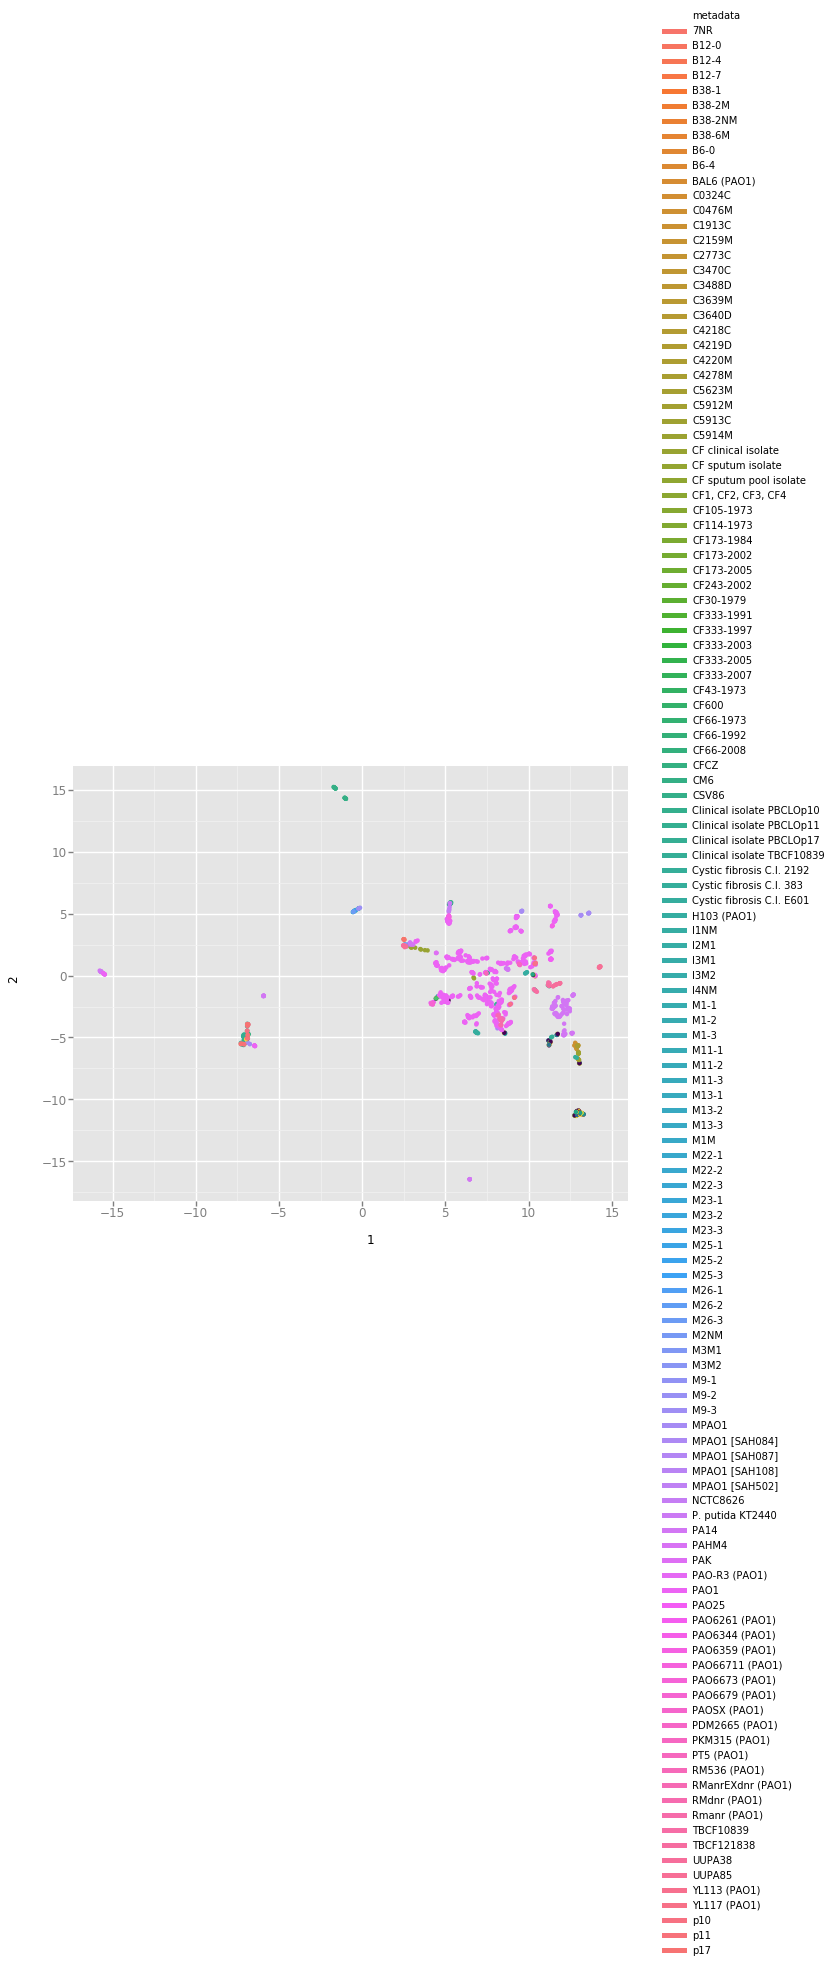

<ggplot: (8786277944142)>

In [8]:
# Plot
ggplot(aes(x='1',y='2', color='metadata'), data=embedding_df) + geom_point()
#plt.scatter(embedding[:, 0], embedding[:, 1]) #, c=[sns.color_palette()[x] for x in metadata.experiment])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Iris dataset', fontsize=24);